
## For the theory behind this algorithm, see Chapter 9 in the textbook Intro to Statistical Learning

We start by adding the libraries we need.

Note that comments are still needed everywhere in this code, and the accuracy check is also needed.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Done


In [ ]:
def load_data(filepath): # input argument is a string of the filepath
    data = pd.read_csv(filepath) # pandas function for reading in the csv into a nice dataframe

    # We'll use the matrix equation X b = Y. X cntains the data/'coefficients'
    # Y contains the labels of classification
    diagnosis = pd.get_dummies(data['diagnosis']) #This is our Y
    data = data.drop('diagnosis', axis=1) #we want to separate it from X

    id = data['sample_id']
    data = data.drop('sample_id', axis=1)
    #we may want to rethink if we should drop all of these. It might be easiest
    #eventually to use the sample id for the accuracy check
    data = data.drop('sample_origin', axis=1)
    sex = pd.get_dummies(data['sex']) # need to make this column of M F into binary
    data['sex'] = sex['F'] # female are 1, male are 0
    data = data.drop('patient_cohort', axis=1)
    data = data.drop('benign_sample_diagnosis', axis=1)
    data = data.drop('plasma_CA19_9', axis=1)
    data = data.drop('REG1A', axis=1)
    data = data.drop('stage', axis = 1) #I don't think we care about the things that are dropped here
    X = data.values
    Y = diagnosis.values

    return (X, Y)

Note that this SVM code will only do binary classification. However, we can do a two-step classification.


1.   Classify as DISEASE or CONTROL
2.   Of those in the disease category, classify as CANCER or DISEASE



In [ ]:
# function for SVM
def svm(x_train, y_train, numObs, numFeat, maxIter):

    weights = np.zeros((numObs, numFeat))
    weights = np.array(weights)

    # these could also be parameters that we input if wanted
    iter_count = 1
    alpha = 0.0001
    showTrigger = 1000

    ## training the algorithm
    while (iter_count < maxIter): # until we reach maxIter

        y = weights[:,0]*x_train[:,0]
        for i in range(1,numFeat): # we need basically a dot product between the weights and the training data
            y = y + weights[:,i] * x_train[:,i]

        y = y.reshape(numObs, 1)
        prod = y * y_train
        count = 0
        if (iter_count % showTrigger) == 0:
            print(iter_count)
        for val in prod:
            if (val >= 1):
                for col in range(numFeat):
                    weights[:,col] = weights[:,col] - alpha * (2 * 1 / iter_count * weights[:,col])

            else:
                for col in range(numFeat):
                    weights[:,col] = weights[:,col] + alpha * (x_train[count,col] * y_train[count] - 2 * 1 / iter_count * weights[:,col])

            count += 1
        iter_count += 1
    return weights

In [ ]:
def check_accuracy(weights, x_test, y_test):
    num_Test, num_Feat = np.shape(x_test)
    weights = weights[0:num_Test,:]

    ## Predict
    y_pred = weights[:, 0] * x_test[:, 0]
    for i in range(1, numFeat):
        y_pred = y_pred + weights[:, i] * x_test[:, i]
    predictions = []
    for val in y_pred:
        if (val > 0):
            predictions.append(1)
        else:
            predictions.append(-1)

    return predictions, y_pred

In [ ]:
# Driver part of the code
maxIter = 10000
X, Y = load_data('Debernardi_et_al_2020_data.csv')
# we'll need to pick the right col of Y for the 2-step binary classification
Y_cvd = Y[:,0] # this is control v. disease (selecting the first row since it will have 1 for control, 0 for everything else)

for i in range(len(Y_cvd)):
  if Y_cvd[i] == 0:
    Y_cvd[i] = -1

X, Y_cvd = shuffle(X,Y_cvd)

x_train, x_test, y_train_cvd, y_test_cvd = train_test_split(X, Y_cvd, train_size=0.9)

x_train = np.array(x_train)
y_train_cvd = np.array(y_train_cvd, dtype = np.int8)
x_test = np.array(x_test)
y_test_cvd = np.array(y_test_cvd, dtype = np.int8)

numObs = np.shape(y_train_cvd)[0]
numFeat = np.shape(x_train)[1]
numTest = np.shape(y_test_cvd)[0]

y_train = y_train_cvd.reshape(numObs,1)
y_test = y_test_cvd.reshape(numTest,1)

weights = svm(x_train, y_train,numObs, numFeat,maxIter)



1000
2000
3000
4000
5000
6000
7000
8000
9000


In [ ]:
pred, y_pred = check_accuracy(weights, x_test, y_test)

In [ ]:
acc_count = 0
for i in range(len(y_test)):
  if y_test[i][0] == pred[i]:
    acc_count = acc_count + 1
acc_count

45

In [ ]:
# what fraction correct?
acc_count / len(y_test)

0.7627118644067796

In [ ]:
# number of training points
np.shape(x_train)

(531, 6)

In [ ]:
m = np.array(pred)
m = m.reshape((len(m), 1))
X_plot = np.concatenate((x_test, m), axis=1)
X_plot = pd.DataFrame(X_plot)

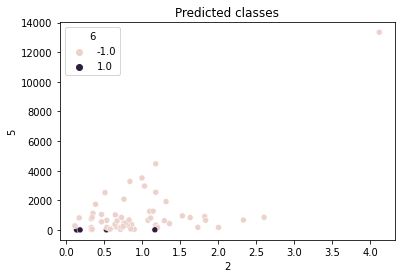

In [ ]:
import seaborn as sns

sns.scatterplot(data=X_plot, x=X_plot[2], y=X_plot[5],hue=X_plot[6])
plt.title('Predicted classes')
plt.show()

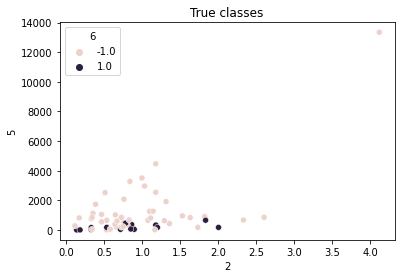

In [ ]:

X_plot2 = np.concatenate((x_test, y_test), axis=1)
X_plot2 = pd.DataFrame(X_plot2)
sns.scatterplot(data=X_plot2, x=X_plot2[2], y=X_plot2[5],hue=X_plot2[6])
plt.title('True classes')
plt.show()

In [ ]:
# now we'll do disease vs cancer
# Driver part of the code
maxIter = 10000
X, Y = load_data('Debernardi_et_al_2020_data.csv')

# we'll need to pick the right col of Y for the 2-step binary classification
Y_cvd = Y[:,0] # this is control v. disease (selecting the first row since it will have 1 for control, 0 for everything else)
Y_cancer = Y[:,2]

#let's drop all of the control people
idx = np.where(Y_cvd == 1)
idx = list(idx[0])
Y_cancer = np.delete(Y_cancer, idx) #gets rid of all rows in the array for control
X_copy = pd.DataFrame(X)
X_cancer = X_copy.drop(index=idx) # same for observations
X_cancer = np.array(X_cancer)


In [ ]:
for i in range(len(Y_cancer)):
  if Y_cancer[i] == 0:
    Y_cancer[i] = -1 # -1 stands for disease

X_cancer, Y_cancer = shuffle(X_cancer,Y_cancer)

x_train_cancer, x_test_cancer, y_train_cancer, y_test_cancer = train_test_split(X_cancer, Y_cancer, train_size=0.9)

x_train_cancer = np.array(x_train_cancer)
y_train_cancer = np.array(y_train_cancer, dtype = np.int8)
x_test_cancer = np.array(x_test_cancer)
y_test_cancer = np.array(y_test_cancer, dtype = np.int8)

numObs = np.shape(y_train_cancer)[0]
numFeat = np.shape(x_train_cancer)[1]
numTest = np.shape(y_test_cancer)[0]

y_train_cancer = y_train_cancer.reshape(numObs,1)
y_test_cancer = y_test_cancer.reshape(numTest,1)

weights_cancer = svm(x_train_cancer, y_train_cancer,numObs, numFeat,maxIter)

1000
2000
3000
4000
5000
6000
7000
8000
9000


In [ ]:
pred_cancer, y_pred_cancer = check_accuracy(weights_cancer, x_test_cancer, y_test_cancer)
acc_count = 0
for i in range(len(y_test_cancer)):
  if y_test_cancer[i][0] == pred_cancer[i]:
    acc_count = acc_count + 1
acc_count

25

In [ ]:
# what fraction correct?
acc_count / len(y_test_cancer)

0.6097560975609756

In [ ]:
# number of training points used
np.shape(x_train_cancer)

(366, 6)

In [ ]:
pred_cancer = np.array(pred_cancer)
m = pred_cancer.reshape(len(pred_cancer),1)
X_plot = np.concatenate((x_test_cancer, m), axis=1)
X_plot = pd.DataFrame(X_plot)


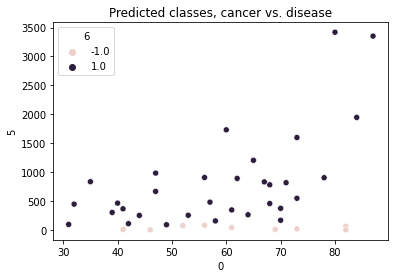

In [ ]:
import seaborn as sns

sns.scatterplot(data=X_plot, x=X_plot[0], y=X_plot[5],hue=X_plot[6])
plt.title('Predicted classes, cancer vs. disease')
plt.show()

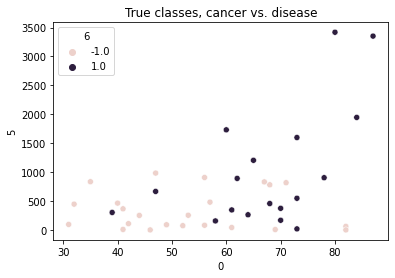

In [ ]:

X_plot2 = np.concatenate((x_test_cancer, y_test_cancer), axis=1)
X_plot2 = pd.DataFrame(X_plot2)
sns.scatterplot(data=X_plot2, x=X_plot2[0], y=X_plot2[5],hue=X_plot2[6])
plt.title('True classes, cancer vs. disease')
plt.show()